# CMRM Homework Assignment No. 2 (HW2)

In [1]:
# Import libraries and modules
import os
import librosa
from matplotlib import pyplot as plt
from matplotlib import colors as pltcol
import IPython.display as ipd
import pretty_midi as midi
import pandas as pd
import glob 
import numpy as np
from sklearn import decomposition as skl
import nmf_utils as nmf


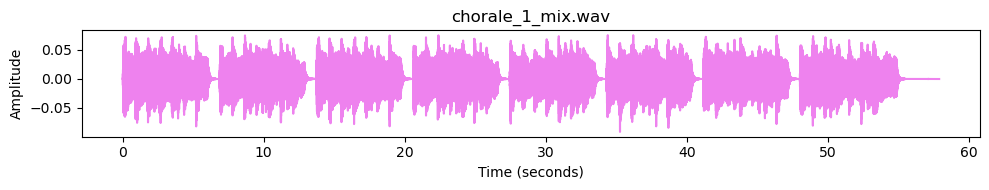

In [2]:
#data folders 
midi_dir = 'data/chorales/midi'
mix_dir = 'data/chorales/mix'
wav_dir = 'data/chorales/wav'

number = 1
source_names = ['soprano', 'alto', 'tenor', 'bass']

#import audio
fn_wav = os.path.join(mix_dir, f'chorale_{number}_mix.wav')
x, Fs = librosa.load(fn_wav, sr=None)

def plot_play(x, Fs, title=None, figure=True, play=True):
    """plot and play function for wav files

    Args:
        x: signal
        sr: sample rate
        title: title of the plot  

    Returns:
        None
    """
    time=librosa.samples_to_time(range(len(x)), sr=Fs)
    
    plt.figure(figsize=(10, 2))
    plt.title(title)
    plt.plot(time, x, color='violet')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    if figure:
        plt.show()
    if play:
        ipd.display(ipd.Audio(data=x, rate=Fs))
    
plot_play(x=x, Fs=Fs, title=f'chorale_{number}_mix.wav')



In [3]:
# Define the function 'extract_annotations'

def extract_annotations(midi_dir, number, source_names, verbose=False):
    
    """Extract annotation data contained in the midi file
    
    Args:
        midi_dir: Directory of MIDI files
        number: Number of the chorale to process
        source_names: Name of the sources
        verbose: If set to True, plot piano roll
    
    Returns:
        annotations: list of annotation data in the form [[start, duration, pitch, velocity, label]]
        start: list of note start times
        duration: list of note durations
        pitch: list of note pitches
        velocity: list of note velocity
        label: list of note instrument label (i.e., name of the source)   

    """
    #parameter checking
    if number not in [1,2,3,4]: print('ERROR: invalid number\n Choose from [1-4]')

    #initialize
    annotations = []    # [ [start, duration, pitch, velocity, label], [start, duration, pitch, velocity, label], ... ] 
    start = []          # [ [start, start, ...], [start, start, ...], [], [] ]
    duration = []       # [ [duration, duration, ...], [duration, ...], [], [] ]
    pitch = []          # [ [pitch, pitch, ...], [pitch, ...], [], [] ]
    velocity = []       # [ [], [], [], [] ]
    label = []          # [ [], [], [], [] ]

    # Iterate over source_names ['soprano', 'alto', 'tenor', 'bass']
    for source in source_names:
        
        fn = f'chorale_{number}_{source}.mid'
        midi_file = glob.glob(f"{midi_dir}/*[1-{number}]*{source}*")[0]

        #extract instrument -> using only instruments[0] as each voice is a single instrument already
        midi_obj = midi.PrettyMIDI(midi_file)
        instrument = midi_obj.instruments[0] 

        #collect all instrument's notes
        notes = []
        for note in instrument.notes: 
            notes.append(note)
            annotations.append([note.start, note.duration, note.pitch, note.velocity, source])

        #retrieve midi information
        start.append([note.start for note in notes])
        duration.append([note.duration for note in notes])
        pitch.append([note.pitch for note in notes])
        velocity.append([note.velocity for note in notes])
        label.append([source for _ in notes])
        
        # Plot the piano roll
        if verbose:
            plt.figure(figsize=(10, 4))
            plt.title(fn)
            plt.xlabel('Time (seconds)')
            plt.ylabel('MIDI note')
            cmap = pltcol.ListedColormap(['white', 'violet'])
            plt.imshow(instrument.get_piano_roll(), cmap=cmap, origin='lower', aspect='auto', extent=[0, instrument.get_end_time(), 0, 128]) #[0, 128] is midi notes range
            plt.show()
    
    return annotations, start, duration, pitch, velocity, label

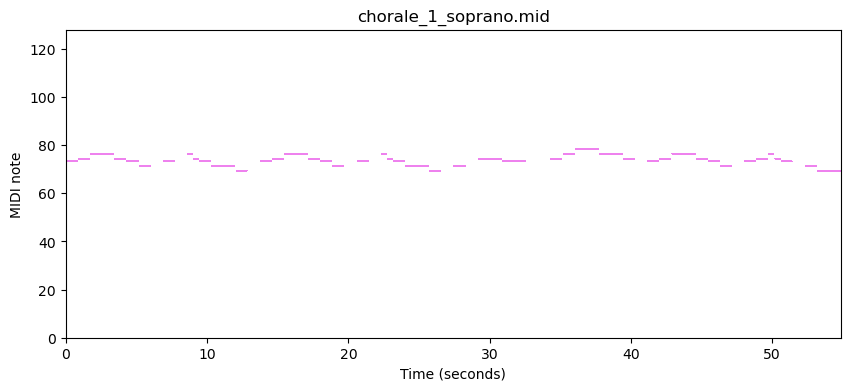

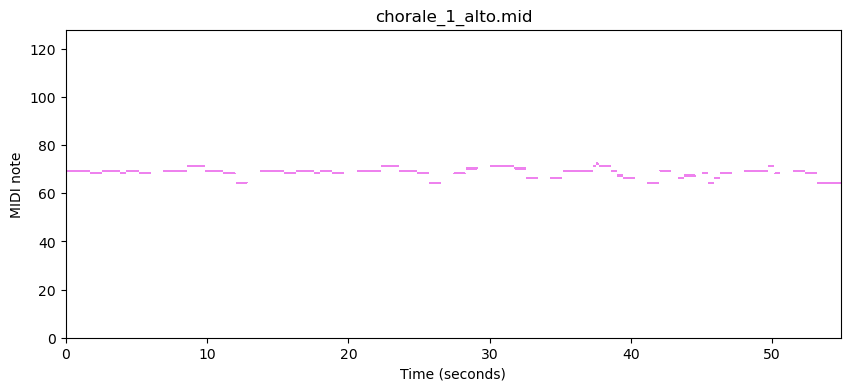

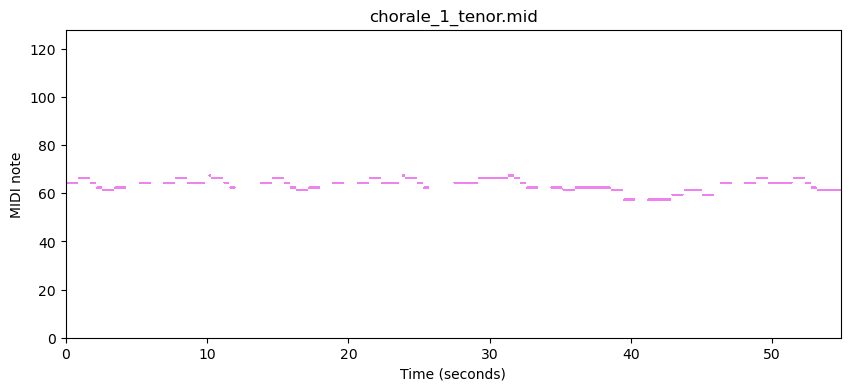

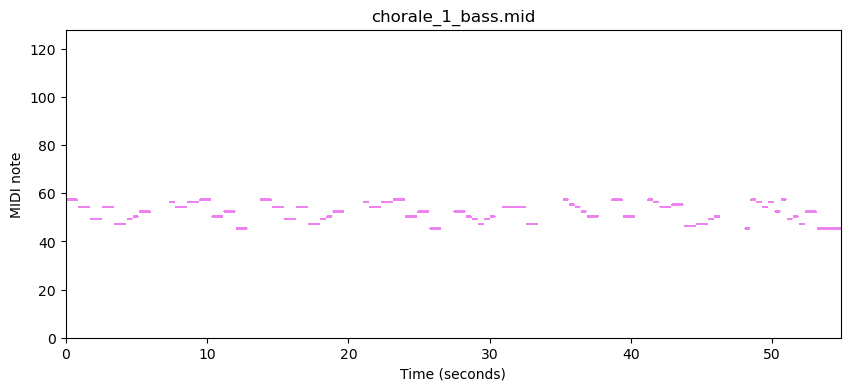

          start            duration pitch velocity    label
0           0.0            0.857143    73       90  soprano
1      0.857143            0.857143    74       90  soprano
2      1.714286  0.8571430000000002    76       90  soprano
3      2.571429  0.8571429999999998    76       90  soprano
4      3.428572  0.8571429999999998    74       90  soprano
..          ...                 ...   ...      ...      ...
233  51.0000085  0.4285714999999968    49       90     bass
234    51.42858  0.4285715000000039    50       90     bass
235  51.8571515  0.4285714999999968    47       90     bass
236   52.285723  0.8571430000000007    52       90     bass
237   53.142866  1.7142860000000013    45       90     bass

[238 rows x 5 columns]


In [4]:
# Extract annotations
annotations, start, duration, pitch, velocity, label = extract_annotations(midi_dir, number, source_names, verbose=True)

keys = ['start', 'duration', 'pitch', 'velocity', 'label']

annotations_df = pd.DataFrame(data = np.array(annotations), columns = keys)
print(annotations_df)


## Question 2

In [5]:
N_fft = 4096
H_fft = N_fft // 4

# Input Spectrogram
stft = librosa.stft(x, n_fft=N_fft, hop_length=H_fft)
V = np.log(1 + np.abs(stft), dtype = np.float64) #because V, H and W must be same dtype

freq_res = Fs / N_fft
frame_res = H_fft / Fs
 
# Spectrogram shape
K = np.shape(V)[0]
N = np.shape(V)[1]

# Initialize activations and templates
tol_note = [0.1, 0.5] 
tol_onset = [0.2, 0.1]
tol_pitch = 0.05

H_init, pitch_set, label_pitch = nmf.initialize_activation(N, annotations, frame_res, tol_note=tol_note, tol_onset=tol_onset)
W_init = nmf.initialize_template(K, pitch_set, freq_res, tol_pitch = 0.05)

# Instantiate NMF model
model = skl.NMF(n_components=np.shape(H_init)[0], solver='mu', init='custom', max_iter=1000)

# NMF factorization
W = model.fit_transform(V, W=W_init, H=H_init)
H = model.components_

V_approx = W.dot(H)

# Error norm
V_approx_err = np.linalg.norm(V-V_approx, ord=2)
print(f'V approx error: {V_approx_err}')


V approx error: 36.42633676602657


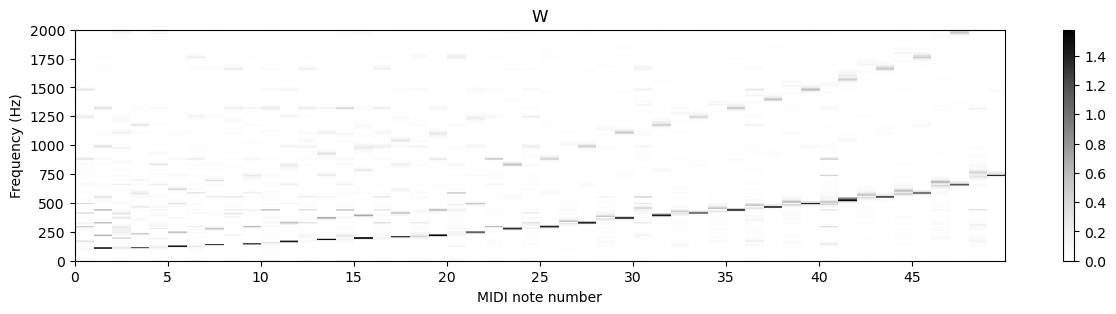

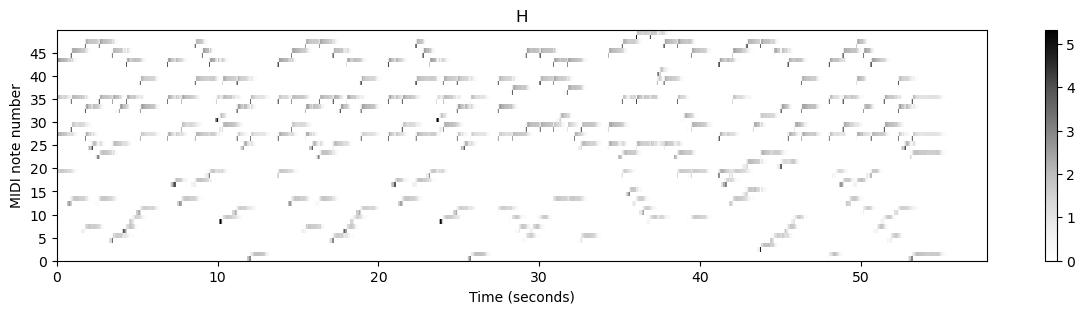

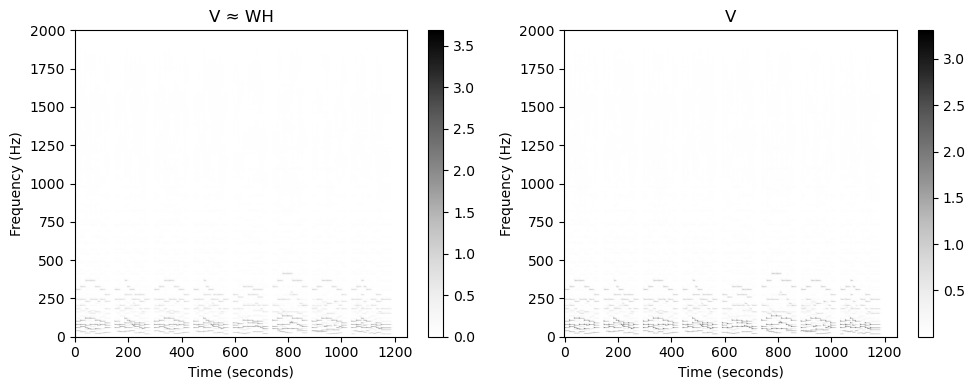

In [64]:
# Plots
R = W.shape[1]
N = H.shape[1]
cmap = 'Greys'

#template matrix W
plt.figure(figsize=(15,3))
plt.title('W')
plt.xlabel('MIDI note number')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 2000])
plt.imshow(W, cmap=cmap, aspect='auto', origin='lower', extent=[0, R, 0, Fs/2], interpolation='nearest')
plt.xticks(np.arange(R, step=5))
plt.colorbar()

#activation matrix H
plt.figure(figsize=(15,3))
plt.title('H')
plt.xlabel('Time (seconds)')
plt.ylabel('MIDI note number')
plt.imshow(H, cmap=cmap, aspect='auto', origin='lower', extent=[0, (N-1) * H_fft / Fs, 0, R], interpolation='nearest')
plt.yticks(np.arange(R, step=5))
plt.colorbar()

#approximated spectrogram vs original spectrogram
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.title('V ≈ WH')
plt.ylim([0, 2000])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.imshow(V_approx, aspect='auto', origin='lower', cmap=cmap)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('V')
plt.ylim([0, 2000])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.imshow(V, aspect='auto', origin='lower', cmap=cmap)
plt.colorbar()

plt.tight_layout()
plt.show()


## Question 3

In [7]:
# Define the function 'split annotations'
def split_annotations(annotations):
    """Split the annotation data into soprano, alto, tenor, and bass
    
    Args: 
        annotations: Annotation data in the form [[start, duration, pitch, velocity, label]]
    
    Returns: 
        ann_sop: Annotation data for soprano
        ann_alt: Annotation data for alto
        ann_ten: Annotation data for tenor
        ann_bas: Annotation data for bass
    """   
            
    return ann_sop, ann_alt, ann_ten, ann_bas

In [8]:
# Split the annotations


# Obtain the spectral masks for each source


# Apply spectral masks


# Plot first source reconstructions



## Question 4

In [9]:
# Soprano source separation


# Alto source separation


# Tenor source separation


# Bass source separation


# Listen to the results using ipd.Audio



## Question 5

In [10]:
# Define the function 'separate'
def separate(x, annotations, N_fft=4096, H_fft=1024):
    """Separate a chorale into its sources (i.e., soprano, alto, tenor, bass)
       through score-informed NMF
       
       Args:
           x: Input audio file
           annotations: Annotation data in the form [[start, duration, pitch, velocity, label]]
           N_fft: Length of the FFT
           H_fft: Hop size of the FFT
           
       Returns:
           x_sop: Soprano audio file
           x_alt: Alto audio file
           x_ten: Tenor audio file
           x_bas: Bass audio file
    """
    
    return x_sop, x_alt, x_ten, x_bas

In [11]:
# Write a pipeline for separating all the chorales into their sources

